In [1]:
!uv pip install tqdm matplotlib seaborn

Audited 3 packages in 2ms


In [2]:
import os
import warnings
warnings.filterwarnings("ignore")

from tqdm import tqdm
import numpy as np
import scipy as sp
import rlfit as rf
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from utils import Bandit

sns.set_theme(style='ticks', font_scale=1.5)
mpl.rcParams["text.usetex"] = True
mpl.rcParams["mathtext.fontset"] = 'cm'
mpl.rcParams['font.family'] = ['sans-serif']

np.random.seed(10015)

In [3]:
repeats = 100
num_steps = 200
p_r = np.array([0.9, 0.1])
p_tr = 0.02
min_beta = 0
max_beta = 5

In [4]:
# generate data
bdt = Bandit(p_r, p_tr)

alphas = []
betas = []
rewards = []  # (repeat, step, reward)
actions = []  # (repeat, step, action)
pis = []
lls = []
for rp in range(repeats):
    alpha = np.random.uniform()
    beta = np.random.uniform(min_beta, max_beta)
    alphas.append(alpha)
    betas.append(beta)

    reward, action, value = bdt.generate_data(alpha, beta, num_steps)
    action_vec = []
    for a in action:
        a_vec = np.zeros(bdt.num_arms)
        a_vec[a] = 1
        action_vec.append(a_vec)

    rewards.append(reward)
    actions.append(action_vec)
    pis.append(np.exp(value) / np.sum(np.exp(value), axis=-1, keepdims=True))
    lls.append(np.sum(np.sum(np.multiply(value, action_vec), axis=-1) - sp.special.logsumexp(value, axis=1)))

In [5]:
# fit the model
cvx_lls = []
cvx_pis = []
cvxloc_lls = []
cvxloc_pis = []
cvxloc_alphas = []
cvxloc_betas = []
for rews, acts in tqdm(zip(rewards, actions), total=len(rewards)):
    acts = np.array(acts)
    model = rf.RLFit(horizon_len=5, share_param=True)
    model.fit(rews, acts)
    cvx_lls.append(model.score(rews, acts))
    cvx_pis.append(model.predict(rews))

    # recover model parameters
    model.fit_param(max_beta=5)
    cvxloc_alphas.append(model.alpha_[0])
    cvxloc_betas.append(model.beta_[0])
    cvxloc_lls.append(model.score(rews, acts))
    cvxloc_pis.append(model.predict(rews))

100%|█████████████████████████████████████████| 100/100 [00:33<00:00,  2.95it/s]


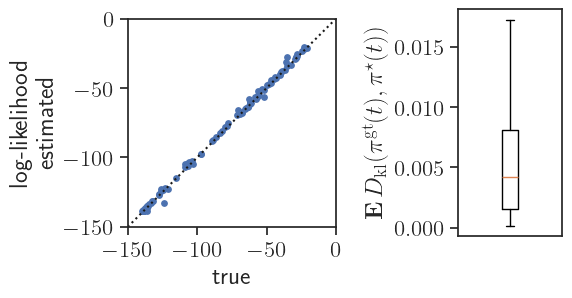

In [6]:
# results without recovering the model parameters
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(6, 3.5), width_ratios=(2, 1))
axs[0].scatter(lls, cvx_lls, s=15)
axs[0].plot((-150, 0), (-150, 0), linestyle='dotted', color='k')
axs[0].set_ylim(-150, 0)
axs[0].set_xlim(-150, 0)
axs[0].set_aspect('equal', 'box')
axs[0].set_xlabel("true")
axs[0].set_ylabel("log-likelihood\nestimated")

kls = []
for pi, htpi in zip(pis, cvx_pis):
    kls.append(np.mean(np.sum(sp.special.kl_div(pi, htpi), axis=-1), axis=-1))
axs[1].boxplot(kls, showfliers=False)
axs[1].set_xticks([])
axs[1].set_ylabel(r"$\mathop{\bf E{}} D_{\rm kl}(\pi^{\rm gt}(t), \pi^\star(t))$")

plt.tight_layout()

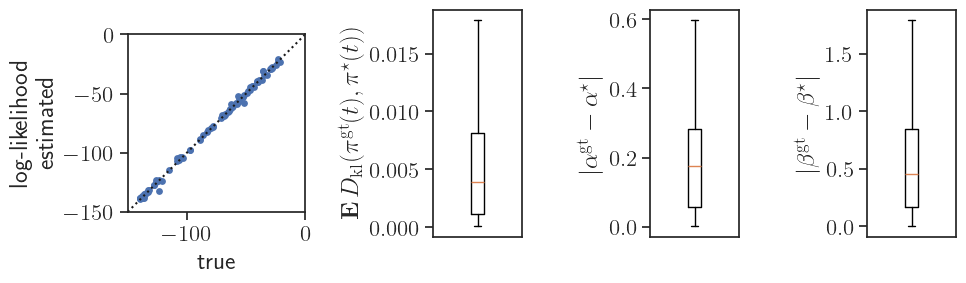

In [7]:
# results after recovering the model parameters
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(10, 3.5), width_ratios=(2, 1, 1, 1))
axs[0].scatter(lls, cvxloc_lls, s=15)
axs[0].plot((-150, 0), (-150, 0), linestyle='dotted', color='k')
axs[0].set_ylim(-150, 0)
axs[0].set_xlim(-150, 0)
axs[0].set_aspect('equal', 'box')
axs[0].set_xlabel("true")
axs[0].set_ylabel("log-likelihood\nestimated")

kls = []
for pi, htpi in zip(pis, cvxloc_pis):
    kls.append(np.mean(np.sum(sp.special.kl_div(pi, htpi), axis=-1), axis=-1))
axs[1].boxplot(kls, showfliers=False)
axs[1].set_xticks([])
axs[1].set_ylabel(r"$\mathop{\bf E{}} D_{\rm kl}(\pi^{\rm gt}(t), \pi^\star(t))$")

errs = []
for a, hta in zip(alphas, cvxloc_alphas):
    errs.append(np.linalg.norm(a - hta, ord=2))
axs[2].boxplot(errs, showfliers=False)
axs[2].set_xticks([])
axs[2].set_ylabel(r"$|\alpha^{\rm gt} - \alpha^\star|$")

errs = []
for b, htb in zip(betas, cvxloc_betas):
    errs.append(np.linalg.norm(b - htb, ord=2))
axs[3].boxplot(errs, showfliers=False)
axs[3].set_xticks([])
axs[3].set_ylabel(r"$|\beta^{\rm gt} - \beta^\star|$")

plt.tight_layout()